# Crop Water Stress Index

* **Products used:** 
[ls8_st](https://explorer.digitalearth.africa/ls8_st), 
[ERA5 Climate Data](https://registry.opendata.aws/ecmwf-era5/)


## Background

One of the well-known measures of plant health is canopy temperature. As 

Jackson et al. (1988) refers to the Crop Water Stress Index as:

\begin{equation}
\text{CWSI} = \frac{\left(T_c - T_a\right) - \left( T_c - T_a \right)_{ll}}{\left(T_c - T_a\right) - \left( T_c - T_a \right)_{ul}}
\end{equation}

where

* $T_c$ is crop temperature
* $T_a$ is air temperature
* $ll$ stands for *lower limit* of the temperature difference
* $ul$ stands for *upper limit* of the temperature difference

For theoretical estimations, $\Delta T_{ul}$ and $\Delta T_{ll}$ are calculated from the energy balance equation and a variety of esoteric measurements including aerodynamic resistance. In practice, Jackson et al. state: 
> The purpose of the upper and lower limits is to form bounds by which the measured temperature can be normalised.

In this case, we will use measurements of air temperature modelled by ERA5, and Landsat surface temperature to approximate CWSI. This modifies Jackson et al.'s equation 

In [1]:
%matplotlib inline

import datacube
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
from odc.algo import xr_reproject

from deafrica_tools.load_era5 import load_era5
from deafrica_tools.datahandling import load_ard, mostcommon_crs
from deafrica_tools.plotting import rgb, display_map

/env/lib/python3.8/site-packages/geopandas/_compat.py:106: UserWarning: The Shapely GEOS version (3.8.0-CAPI-1.13.1 ) is incompatible with the GEOS version PyGEOS was compiled with (3.9.1-CAPI-1.14.2). Conversions between both will be slow.
  warnings.warn(


In [2]:
dc = datacube.Datacube(app="Landsat_ST_CWSI")

In [3]:
# arguments for loading data 

lon = 30.379
lat = 30.177
buffer = 0.07

lat_range = (lat-buffer, lat+buffer)
lon_range = (lon-buffer, lon+buffer)

time = ('2018-07-01', '2019-05-31')

measurements = ['surface_temperature', 'surface_temperature_quality']

In [4]:
display_map(lon_range, lat_range)

In [5]:
# use load_ard to load data

ds = load_ard(dc=dc,
               products=['ls8_st'],
               x=lon_range,
               y=lat_range,
               time=time,
               measurements = measurements,
               output_crs = 'EPSG:32633',
               resolution = (-30, 30))

ds

Using pixel quality parameters for USGS Collection 2
Finding datasets
    ls8_st
Applying pixel quality/cloud mask
Re-scaling Landsat C2 data
Loading 21 time steps


<xarray.Dataset>
Dimensions:                      (time: 21, x: 531, y: 590)
Coordinates:
  * time                         (time) datetime64[ns] 2018-07-07T08:29:09.00...
  * y                            (y) float64 3.449e+06 3.449e+06 ... 3.432e+06
  * x                            (x) float64 1.982e+06 1.982e+06 ... 1.997e+06
    spatial_ref                  int32 32633
Data variables:
    surface_temperature          (time, y, x) float32 324.53925 ... 325.60907
    surface_temperature_quality  (time, y, x) float32 1.5699999 ... 1.7099999
Attributes:
    crs:           EPSG:32633
    grid_mapping:  spatial_ref

In [6]:
# remove NaNs and convert from Kelvin to Celsius
ds = ds.dropna(dim='time', how='all')
ds['surface_temperature'] = ds.surface_temperature - 273.15

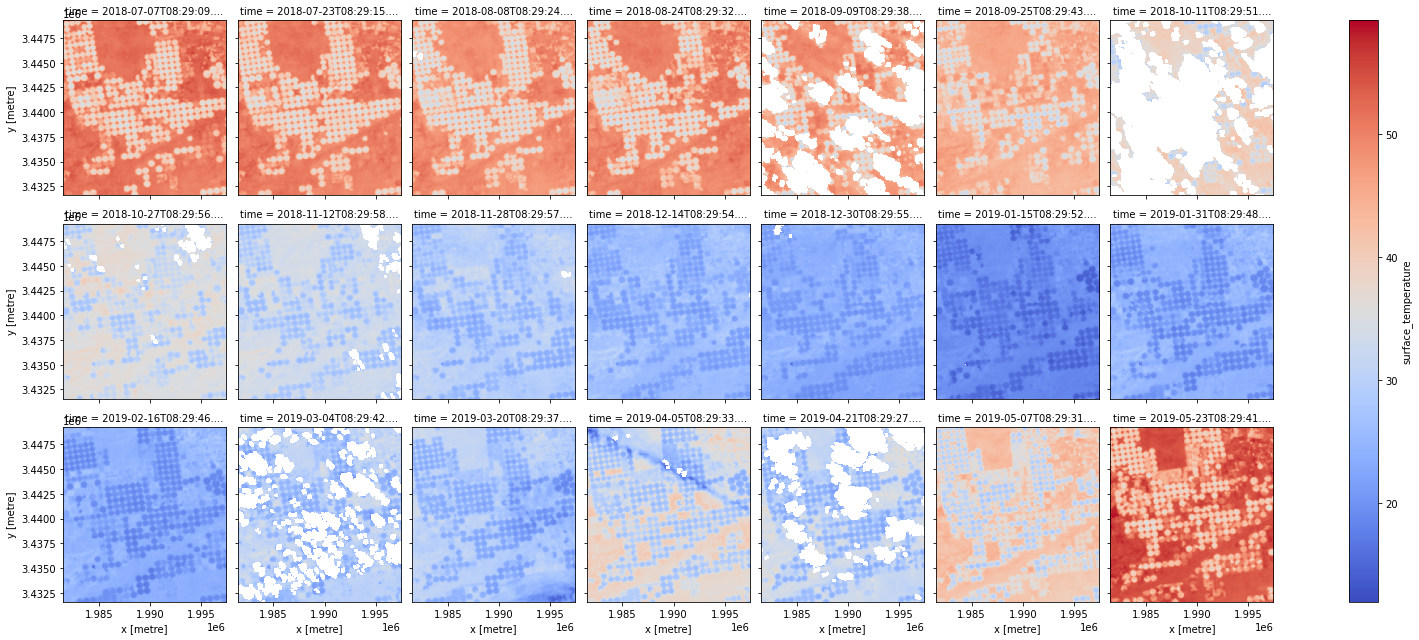

In [7]:
ds.surface_temperature.plot.imshow(col='time', col_wrap=7, cmap='coolwarm');

In [8]:
# load ERA5 air temperature at 2m height
var = 'air_temperature_at_2_metres'
air_temp = load_era5(var, lat_range, lon_range, time, reduce_func=np.mean)[var] - 273.15

In [9]:
ds_mean = ds.groupby('time').mean(dim=xr.ALL_DIMS)

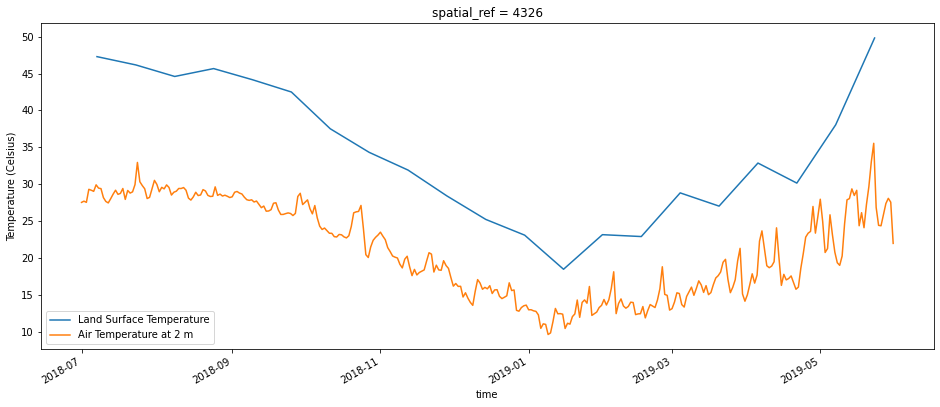

In [10]:
ds_mean.surface_temperature.plot(figsize = (16, 6),label='Land Surface Temperature');
air_temp.groupby('time').mean(dim=xr.ALL_DIMS).plot(label='Air Temperature at 2 m');
plt.ylabel('Temperature (Celsius)')
plt.legend()

### The above plot is cool but we don't actually need it for CWSI. Moving on:

In [11]:
# match timestamps from ds to air_temp
# find diff between T_c (ds) and T_a (air_temp)
# find min and max diffs
# approximate the cwsi

In [12]:
# normalise datetime values (remove hour/min) so we can match them
air_temp['time'] = air_temp.indexes['time'].normalize()
ds['time'] = ds.indexes['time'].normalize()

In [13]:
# match times, compute air_temp (take out of chunks), and rename dims to match
air_temp_ds = air_temp.sel(time=ds.time)
air_temp_ds = air_temp_ds.compute()
air_temp_ds.rename({'lon': 'x','lat': 'y'});

In [14]:
air_temp_ds_reproj = xr_reproject(src=air_temp_ds,
                                  geobox=ds.geobox,
                                  resampling="bilinear")
# air_temp_ds_reproj

In [15]:
deltat = ds.surface_temperature - air_temp_ds_reproj

In [16]:
ll = deltat.min(dim='time')

In [17]:
ul = deltat.max(dim='time')

In [18]:
cwsi = (deltat - ll)/(ul - ll)

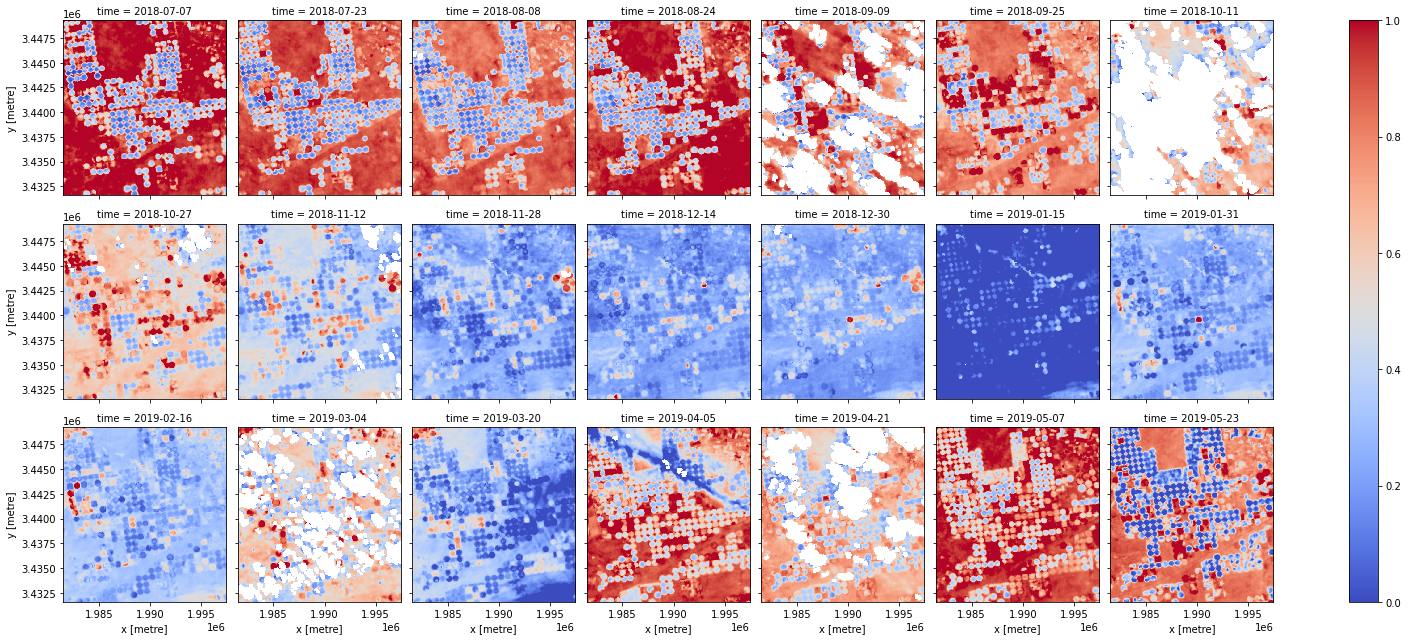

In [19]:
cwsi.plot.imshow(col='time', col_wrap=7, cmap='coolwarm');

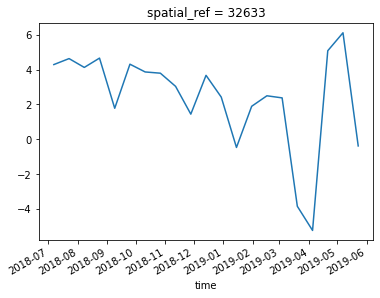

In [20]:
deltat.min(dim=["x",'y']).plot()

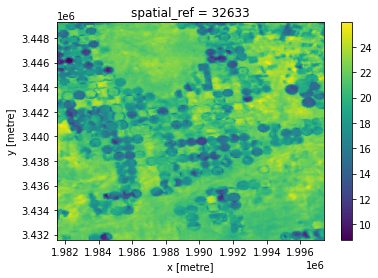

In [21]:
deltat.max(dim='time').plot()

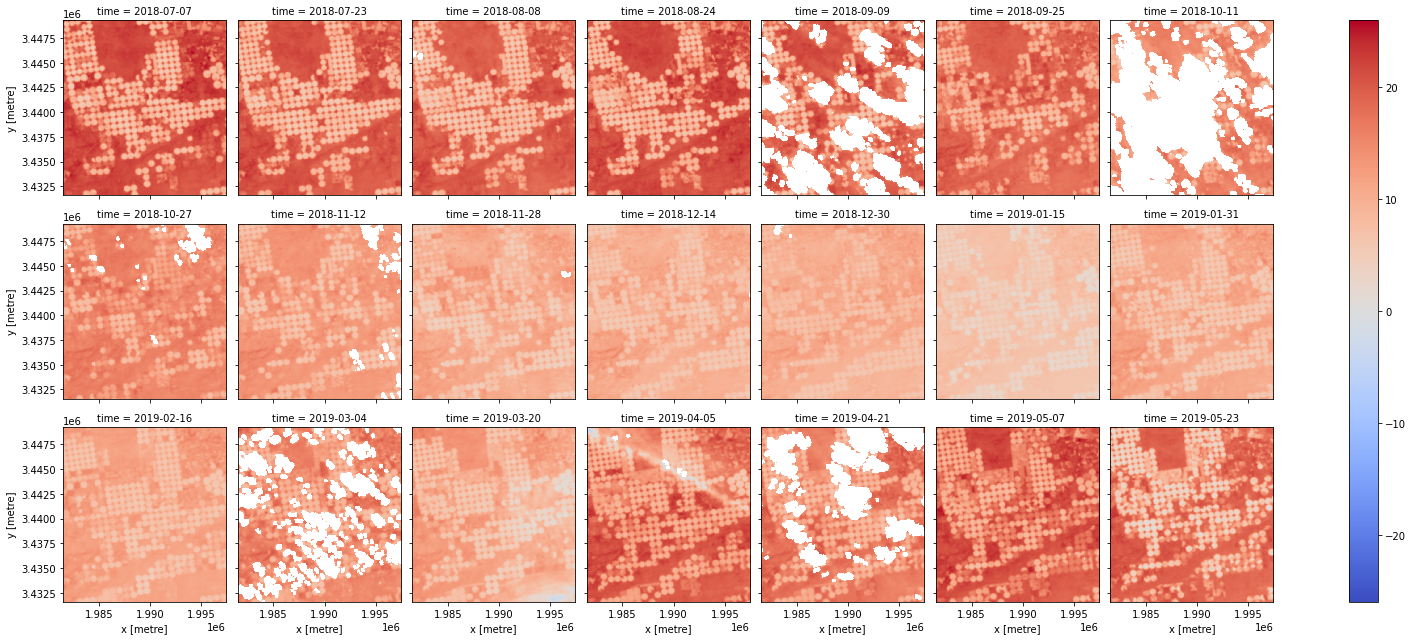

In [22]:
deltat.plot.imshow(col='time', col_wrap=7, cmap='coolwarm');